# Sequence NLP model with IMDB dataset

* IMDB dataset (http://ai.stanford.edu/~amaas/data/sentiment/): Movie review sentences classified as positive or negative. 25,000 traning set, and 25,000 testing set.
* Different types of sequence and convolutional models tested: LSTM, GRU, and 1D convolution.

## Download IMDB dataset

In [1]:
import tensorflow as tf
print(tf.__version__)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

2.0.0-beta1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint

In [2]:
tf.enable_eager_execution()

AttributeError: module 'tensorflow' has no attribute 'enable_eager_execution'

In [4]:
import tensorflow_datasets as tfds

In [5]:
imdb, info = tfds.load("imdb_reviews",with_info=True,as_supervised=True)

W1231 16:36:00.189583 140734814332352 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


## Tokenizing the dataset

* Classification for training and testing data set

In [6]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

# Training
training_sentences = []
training_labels = []

# Testing/Validation
testing_sentences = []
testing_labels = []

# S and l is originally in tf.Tensor format, converting them to numpy arrays
for s,l in train_data:
    training_sentences.append(str(s.numpy())) 
    training_labels.append(l.numpy())

for s,l in test_data:
    testing_sentences.append(str(s.numpy()))
    testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

* Tokenizing both training and testing set
* Padding the sequences to the same length

In [7]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Creating tokenizer with training sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

# Word-index and Index-word dictionaries
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

# Training padded sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, padding='pre', truncating='post')

# Testing padded sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

## Long short term memory (LSTM)

* Instead of simply using flattening, LSTM layer is included after the word embedding
* Total parameters ~ 166k
* LSTM can remember long-distance relationship by the combination of recursion neural network (RNN), cells, and three gates (input, forget, and output).

In [14]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                6272      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 166,477
Trainable params: 166,477
Non-trainable params: 0
_________________________________________________________________


* Traning
* It took ~ 70 s per epoch, which is much slower than simple model without LSTM layer.

In [15]:
num_epochs = 20
history1 = model1.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 72s 3ms/sample - loss: 0.4668 - accuracy: 0.7718 - val_loss: 0.3670 - val_accuracy: 0.8436

* Plotting traning history
* The training result is similar to the simple model without LSTM.
1) Traning accuracy can be up to 0.994.
2) Validation accuracy does not slightly decreases with traning (still > 0.8), while the validation loss continuously increases, indicating the decrease in the prediction confidence, indicating overfitting.


In [48]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    font = 15
    fig = plt.figure(figsize=(4,3))
    plt.plot(history.history[string],'b')
    plt.plot(history.history['val_'+string],'r')
    plt.xlabel("Epochs", fontsize=font)
    plt.ylabel(string, fontsize=font)
    plt.legend([string, 'val_'+string], fontsize=font)
    plt.xlim([0,num_epochs])
    #plt.ylim([-0.1,1.1])
    plt.xticks(fontsize=font)
    plt.yticks(fontsize=font)
    plt.xlim([0,20])
    if string == "accuracy":
        plt.ylim([0.6,1.0])
    elif string == "loss":
        plt.ylim([0,1.5])
    plt.show()



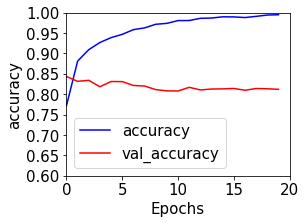

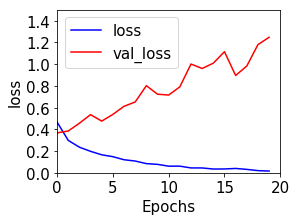

In [49]:
plot_graphs(history1, "accuracy")
plot_graphs(history1, "loss")

## Gated recurrent unit (GRU)

* Here GRU is used instead of LSTM. ~ 164k parameters, slightly lower than LSTM. Most of the parameters come from word embedding.
* GRU has only 2 gates (update and reset gates), while LSTM has 3 gates (input, output, forget gates).
* GRU is simpler, and can be trained faster than LSTM.
* In theory, LSTM should outperform GRU for longer sentences.

In [31]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                4800      
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 198       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 7         
Total params: 165,005
Trainable params: 165,005
Non-trainable params: 0
_________________________________________________________________


* Training
* The training time is ~ 70 s  per epoch, similar to LSTM.

In [32]:
num_epochs = 20
history2 = model2.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 71s 3ms/sample - loss: 0.5193 - accuracy: 0.7170 - val_loss: 0.3755 - val_accuracy: 0.8375

* Plotting training history
* The trend in training is very similar to LSTM.
* Fluctuation in the validation accuracy and loss is smaller.

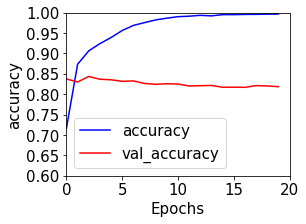

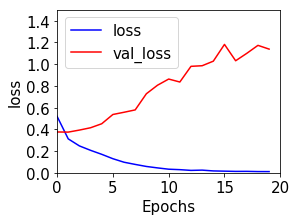

In [50]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

## 1D Convolution

* Here we use 1D convolution layers to extract the connection of neighbor words.
* Additional global average pooling added after the convoalution layer.
* Total parameters ~ 171 k.

In [34]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 774       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________


* Training
* Training time is only ~ 10 s, which is much shorter than LSTM and GRU.

In [35]:
num_epochs = 20
history3 = model3.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 7s 289us/sample - loss: 0.5331 - accuracy: 0.7721 - val_loss: 0.4402 - val_accuracy: 0.8459

* Plotting training history
* The trend in training is very similar to the other two model.
* The maximum length of setences used for training is 120. For longer sentences, LSTM and GRU should outperform this simple convolutoin model.

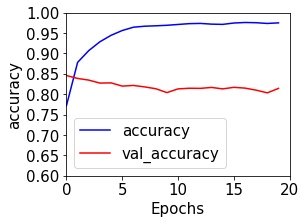

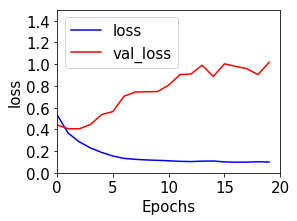

In [51]:
plot_graphs(history3, "accuracy")
plot_graphs(history3, "loss")